# Create a basic 2D dataset with some samples from different databases.

### Many variations of Data Augmentation will be applied in the dataset. Latter, some Deep Learning architecture will be trained and evaluated with these images.

### If results are promising, the database will be expanded.

### The dataset structure was analysed in the 'verify_ds_struct' notebook.

### By convention, all images will be rotated so that the face is pointed to the right.

## Import all required libraries.

In [73]:
import os
import cv2
import glob
import random
import pydicom

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from pathlib import Path

## IXI Dataset

### Although each patient has 256 images in the axial angle, only indexes 120 to 180 will be used.

### The slice at the desired angle does not have a square definition. Instead of applying a reshape, padding will be adopted.

In [19]:
ixi_ds_path = Path('../Datasets/Dataset_IXI')
ixi_scans = os.listdir(ixi_ds_path)

FIRST_IDX = 120
LAST_IDX = -75
PAD_WIDTH = (256-150)//2 

ixi_ds = []

for curr_pat in ixi_scans:

    scan_path = os.path.join(ixi_ds_path, curr_pat)
    f = nib.load(scan_path)
    scan_array = f.get_fdata()

    for idx in range(FIRST_IDX, scan_array.shape[1]+LAST_IDX, 5):
        img = scan_array[:,idx,:]
        img = np.pad(img, ((0,0),(PAD_WIDTH, PAD_WIDTH)), 'constant')

        slice_info = ['IXI', curr_pat.split('.')[0], idx, 
                            np.rot90(img), False, None]
        ixi_ds.append(slice_info)

np.array(ixi_ds).shape

(221, 6)

## HCP Dataset

In [20]:
hcp_ds_path = Path('../Datasets/HCP/hcp')
pat_folders = os.listdir(hcp_ds_path)

hcp_ds = []

FIRST_IDX = 35
LAST_IDX = -44

NEW_WIDTH = 240
NEW_HEIGHT = 200
VERTICAL_PAD = (256 - NEW_HEIGHT)//2
HORIZONTAL_PAD = (256 - NEW_WIDTH)//2

for pat in pat_folders:
    scan_path = os.path.join(hcp_ds_path, pat, 'T1w')
    scan_path = os.path.join(scan_path, os.listdir(scan_path)[0])

    f = nib.load(scan_path)
    img_array = f.get_fdata()

    for slice_idx in range(FIRST_IDX, img_array.shape[-1]+LAST_IDX, 5):

        img = cv2.resize(img_array[:,:,slice_idx], (NEW_WIDTH, NEW_HEIGHT), interpolation=cv2.INTER_CUBIC)

        img = np.pad(img, ((VERTICAL_PAD, VERTICAL_PAD),(HORIZONTAL_PAD, HORIZONTAL_PAD)), 'constant')

        slice_info = ['HCP', pat, slice_idx, img, False, None]

        hcp_ds.append(slice_info)

np.array(hcp_ds).shape

(588, 6)

## TCGA Datasets

### Some samples were downloaded from The Cancer Imaging Archive.
### There are two types of cancer: Glioblastoma (GBM) and Low-Grade Gliomas.
### The code developed below can select some slices from both databases.
### The patients are going to contribute with healthy and cancer slices. The slices must be separated by at least 4 cuts in between.

In [2]:
lgg_folder = Path('../Datasets/Sample_TCGA-LGG/TCGA-LGG')
gbm_folder = Path('../Datasets/Sample_TCGA-GBM/TCGA-GBM')

lgg_ds = []
gbm_ds = []

### A funtion for helping in the slices selection will be created. It just works for the TCGA folders.

In [53]:
def generate_tcga_ds(folder_path, list_ds, cancer_type, first_patient=0):
    patients = os.listdir(folder_path)

    if len(list_ds) == 0: list_ds = []

    for pat in patients[first_patient:]:

        scans_path = sorted(glob.glob(os.path.join(folder_path, pat, '*/*/*')))
        print(f'The patient {pat} has {len(scans_path)} slices.')

        next_patient = False
        last_chosen_idx = -1

        while not next_patient:
            
            opt = input("Which slice would you like to evaluate?\nType 'save' to save, 'next' to change patient and 'stop' to stop program.")
            
            if opt == 'stop':
                return list_ds
            elif opt == 'next':
                next_patient = True
            elif opt == 'save':

                if last_chosen_idx != -1:
                    cancer = input("This slice has cancer or not? Answer with 'yes' or 'no'.")
                    if cancer == 'yes':
                        cancer_bool = True
                        cancer = cancer_type
                    elif 'no':
                        cancer_bool = False
                        cancer = None

                    slice_info = ['TCGA', pat, last_chosen_idx, np.rot90(scan), cancer_bool, cancer]
                    list_ds.append(slice_info)
                    last_chosen_idx = -1
                else:
                    input("You should select an image before saving. Press any key to continue.")

            else:
                try:
                    last_chosen_idx = int(opt) - 1
                    path = scans_path[last_chosen_idx]
                except:
                    input(f"Unavailable option. Choose a slice number in correct range or 'save', 'next' or 'stop'. Press any key to continue.")
                
                if last_chosen_idx != -1:
                    scan = pydicom.read_file(path).pixel_array
                    scan = scan/scan.max() * 255
                    
                    plt.figure(figsize=(7,7))
                    plt.imshow(np.rot90(scan), cmap='gray')
                    plt.title(f"Slice {opt} from patient {pat}.")
                    plt.show()

    return list_ds

### Let's start with the GBM files.

In [54]:
gbm_ds = generate_tcga_ds(gbm_folder, gbm_ds, 'GBM')

The patient TCGA-02-0003 has 124 slices.


In [30]:
np.array(gbm_ds).shape

(91, 6)

In [27]:
tcga_gbm_df = pd.DataFrame(gbm_ds, columns=['Orig_Dataset', 'Patient_ID', 'Slice_Idx', 'Image', 'Cancer', 'Cancer_Type'])
tcga_gbm_df.to_pickle(os.path.join(gbm_folder, 'gbm_images.pickle'))

### Now the LGG files.

The patient TCGA-CS-5393 has 120 slices.
The patient TCGA-DU-7008 has 52 slices.
The patient TCGA-CS-6188 has 200 slices.
The patient TCGA-DU-6399 has 53 slices.


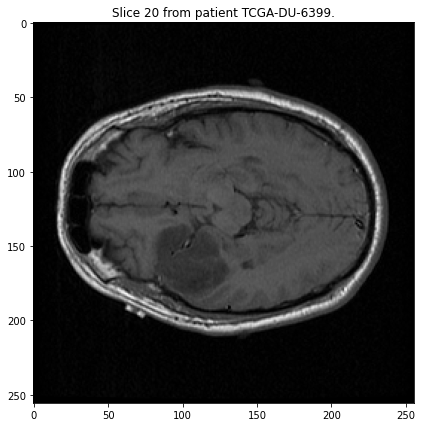

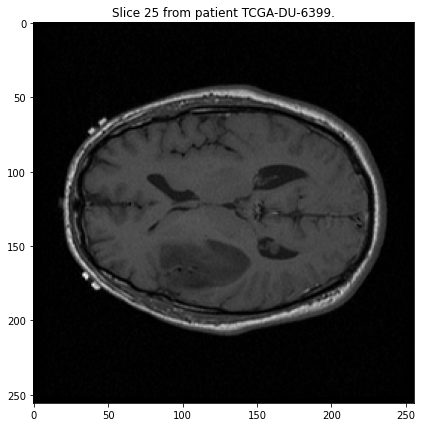

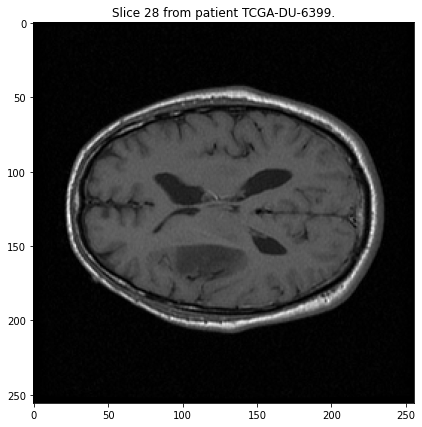

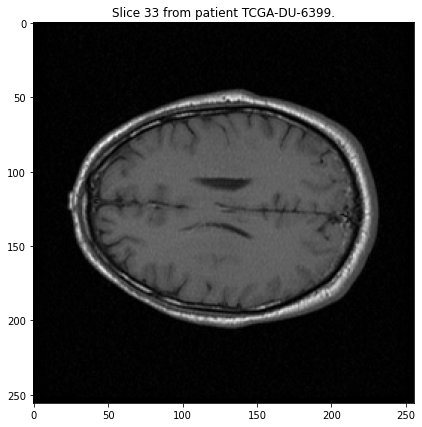

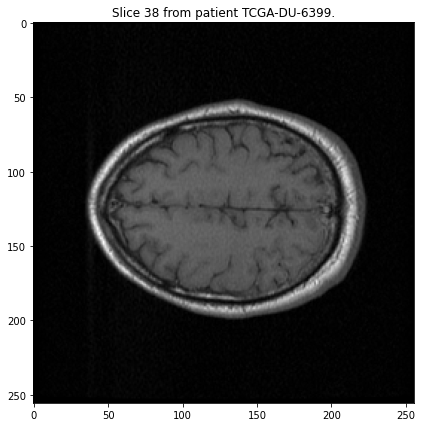

In [60]:
lgg_ds = generate_tcga_ds(lgg_folder, lgg_ds, 'LGG', 35)

In [61]:
#lgg_ds[-5:]
#lgg_ds.pop(-1)

np.array(lgg_ds).shape

(123, 6)

In [62]:
tcga_lgg_df = pd.DataFrame(lgg_ds, columns=['Orig_Dataset', 'Patient_ID', 'Slice_Idx', 'Image', 'Cancer', 'Cancer_Type'])
tcga_lgg_df.to_pickle(os.path.join(lgg_folder, 'lgg_images.pickle'))

## Matlab Dataset

### The dataset only contains images with axial views.

In [57]:
matlab_path = Path('../Datasets/MatLab_DS/axial_df.pickle')
matlab_df = pd.read_pickle(matlab_path)

matlab_df.shape

(691, 7)

In [58]:
matlab_df.head()

Orig_File Patient_ID                                        Slice_Image  \
0        1.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2509     5.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2398     4.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2222     3.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1111     2.mat     100360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             Tumor_Mask  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2509  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2398  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2222  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1111  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           Tumor_Border  Tumor_Label  \
0     [[267.6152450090744, 231.37568058076226, 277.8...          1.0   
2509  [[286.32752613240416, 231.9163763066202, 297.0...          1.0   
2398  [[279.191637630662, 237.26829268292684, 293.46...          1.0   
2222  [[280.08362369337976, 173.0452961672474, 273.8...          1.0   
1111  [[319.33101045296166, 153.42160278745644, 302....          1.0   

      Axial_View  
0           True  
2509        True  
2398        True  
2222        True  
1111        True

### Build dataset in the same format as the others.

In [104]:
format_ml_df = matlab_df.filter(['Orig_File', 'Patient_ID', 'Slice_Image', 'Tumor_Label'])

format_ml_df.insert(0, "Orig_Dataset", "Matlab")
format_ml_df.insert(4, "Cancer", True)

format_ml_df = format_ml_df.rename(columns={"Orig_File":"Slice_Idx", "Slice_Image":"Image", "Tumor_Label":"Cancer_Type"})

format_ml_df = format_ml_df[["Orig_Dataset", "Patient_ID", "Slice_Idx", "Image", "Cancer", "Cancer_Type"]]

format_ml_df['Cancer_Type'] = format_ml_df['Cancer_Type'].map({1:"Meningioma",2:"Glioma",3:"Pituitary Tumor"})

format_ml_df = format_ml_df.reset_index(drop=True)

format_ml_df.head()

Orig_Dataset Patient_ID Slice_Idx  \
0       Matlab     100360     1.mat   
1       Matlab     100360     5.mat   
2       Matlab     100360     4.mat   
3       Matlab     100360     3.mat   
4       Matlab     100360     2.mat   

                                               Image  Cancer Cancer_Type  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    True  Meningioma  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    True  Meningioma  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    True  Meningioma  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    True  Meningioma  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    True  Meningioma

### All images from this dataset are 512x512. Then, we need to resize all.

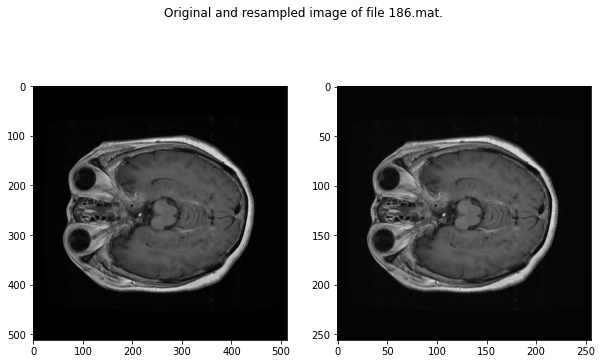

In [82]:
random_idx = random.randint(0,len(format_ml_df))

img = format_ml_df.iloc[random_idx].Image
name = format_ml_df.iloc[random_idx].Slice_Idx

resampled_img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

fig = plt.figure(figsize=(10,6))
fig.suptitle(f"Original and resampled image of file {name}.")

sub_orig = fig.add_subplot(1,2,1).imshow(img, cmap='gray')
sub_rs = fig.add_subplot(1,2,2).imshow(resampled_img, cmap='gray')

plt.show()

### The resample process is quite efficient. Let's map the function is the whole dataframe.

In [105]:
#formatlist(map(lambda idx: format_ml_df.iloc[idx].Image = cv2.resize(format_ml_df.iloc[idx].Image, (256, 256), interpolation=cv2.INTER_CUBIC), range(len(format_ml_df)))

format_ml_df['Image'] = format_ml_df.Image.apply(
    lambda img: cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
)

dict_shapes = {}

for idx, row in format_ml_df.iterrows():
    shape = row['Image'].shape
    if shape not in dict_shapes:
        dict_shapes.update({shape : 1})
    else:
        dict_shapes[shape] += 1

dict_shapes

{(256, 256): 691}

## Merge Datasets.

### The cells that menage datasets IXI, HCP and MatLab must be runned before merging all of them.
### The ones from TCGA are redeemed from pickle files.

In [106]:
lgg_folder = Path('../Datasets/Sample_TCGA-LGG/TCGA-LGG')
gbm_folder = Path('../Datasets/Sample_TCGA-GBM/TCGA-GBM')

tcga_gbm_df = pd.read_pickle(os.path.join(gbm_folder, 'gbm_images.pickle'))
tcga_lgg_df = pd.read_pickle(os.path.join(lgg_folder, 'lgg_images.pickle'))

healthy_ds = ixi_ds + hcp_ds
healthy_df = pd.DataFrame(healthy_ds, columns=['Orig_Dataset', 'Patient_ID', 'Slice_Idx', 'Image', 'Cancer', 'Cancer_Type'])

len(tcga_lgg_df), len(tcga_gbm_df), len(healthy_df), len(format_ml_df)

(123, 91, 809, 691)

In [107]:
total_df = pd.concat([tcga_lgg_df, tcga_gbm_df, healthy_df, format_ml_df])
total_df = total_df.reset_index(drop=True)

total_df.to_pickle('../Datasets/merged_ds.pickle')

## Visualize images from complete dataframe.

### This process will be done by the class EvaluateDataframe.

In [108]:
#test_df = total_df[total_df['Orig_Dataset'] == 'HCP'].iloc[10:20,:]
#total_df.index.get_loc(test_df.iloc[0].Patient_ID)
total_df = pd.read_pickle('../Datasets/merged_ds.pickle')

In [109]:
total_df.head()

Orig_Dataset    Patient_ID Slice_Idx  \
0         TCGA  TCGA-CS-4944        84   
1         TCGA  TCGA-CS-4944        69   
2         TCGA  TCGA-CS-4944        54   
3         TCGA  TCGA-CS-4944        39   
4         TCGA  TCGA-DU-6402        44   

                                               Image  Cancer Cancer_Type  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   False        None  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    True         LGG  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    True         LGG  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   False        None  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   False        None

In [35]:
row = total_df.iloc[3]
row.Cancer = True

total_df.iloc[3] = row
total_df.head()

Orig_Dataset    Patient_ID Slice_Idx  \
0         TCGA  TCGA-CS-4944        84   
1         TCGA  TCGA-CS-4944        69   
2         TCGA  TCGA-CS-4944        54   
3         TCGA  TCGA-CS-4944        39   
4         TCGA  TCGA-DU-6402        44   

                                               Image  Cancer Cancer_Type  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   False        None  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    True         LGG  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    True         LGG  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    True        None  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   False        None

In [56]:
class EvaluateDataframe():

    def __init__(self, df):
        self.df = df


    def get_ds_indexes(self, ds_name):
        indexes = self.df[self.df.Orig_Dataset == ds_name].index
        return indexes[0], indexes[-1]


    def return_df(self):
        return self.df 


    def plot_images(self, first_idx=0, last_idx=None):

        if last_idx is None: last_idx = len(self.df)

        idx = first_idx
        
        poss_cmd = ['n', 'p', 'label', 'rot', 'end']

        while idx != last_idx:
            row = self.df.iloc[idx]
            img = row.Image
            
            plt.figure(figsize=(10,8))
            plt.imshow(img, cmap='gray')
            plt.title(f"DF_index: {idx}; DS: {row.Orig_Dataset}; Patient: {row.Patient_ID}; Label: {row.Cancer}; Type: {row.Cancer_Type}.")
            plt.show()

            valid_cmd = False
            while not valid_cmd:
                valid_cmd = True
                cmd = input("To go to next image, press 'n'; " 
                            "To go to the previous, press 'p'; "
                            "To choose df row, type value; "
                            "To change label, type 'label'; "
                            "To rotate image, type 'rot'; "
                            "To end method, press 'end'.")

                if cmd == 'n': idx += 1
                elif cmd == 'p': cmd -= 1
                elif cmd == 'label': self.df.iloc[idx] = self._change_label(row)
                elif cmd == 'rot': self.df.iloc[idx] = self._rotate_image(row)
                elif cmd == 'end': idx = last_idx
                else:
                    try: 
                        new_idx = int(cmd)
                        if first_idx <= new_idx < last_idx:
                            idx = new_idx
                        else: valid_cmd = False
                    except: valid_cmd = False


    def _change_label(self, row):
        poss_label = ['True', 'False']
        poss_type = self.df.Cancer_Type.unique()
        
        label = ''
        c_type = ''

        while label not in poss_label:
            label = input("What is the label of the last image: 'True' or 'False'?")
            
            if label == 'True':
                while c_type not in poss_type:
                    c_type = input("What's the cancer type?")

                row.Cancer = True
                row.Cancer_Type = c_type
            elif  label == 'False':
                row.Cancer = False
                row.Cancer_Type = None
    
        return row

    def _rotate_image(self, row):
        rot_qtd = -1
        correct_position = False

        while not correct_position:
            while not (0 <= rot_qtd <= 3):

                try:
                    rot_qtd = int(input("How many rotations of 90º should be done? Choose a value between 0 and 3."))
                except:
                    print("It must be an integer.")

            row.Image = np.rot90(row.Image, rot_qtd)

            # Must be removed after df update implementation.
            plt.figure(figsize=(10,8))
            plt.imshow(row.Image, cmap='gray')
            plt.title("New version.")
            plt.show()

            answer = ""
            while answer not in ['yes', 'no']:
                answer = input("Would you like to save the image in this position? Answer with 'yes' or 'no'.")
                if answer == 'yes':
                    correct_position = True
                elif answer == 'no':
                    row.Image = np.rot90(row.Image, (4-rot_qtd))

            rot_qtd = -1

        return row

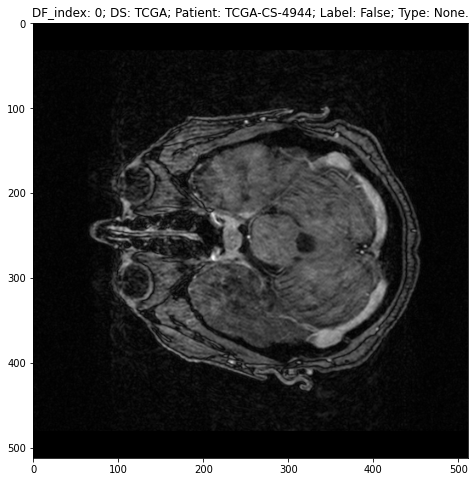

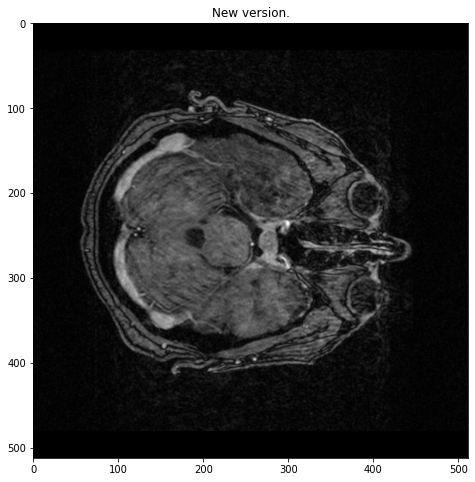

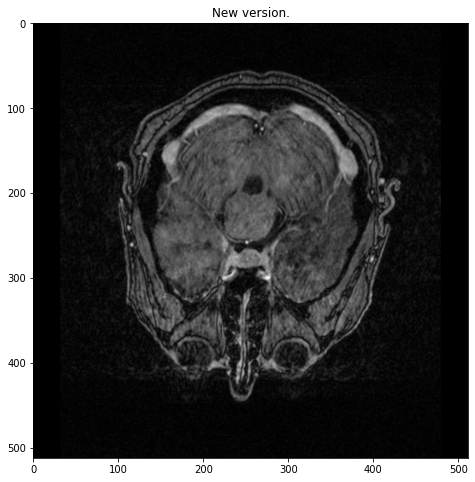

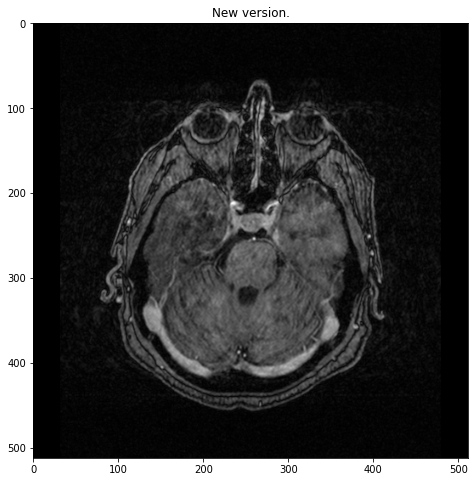

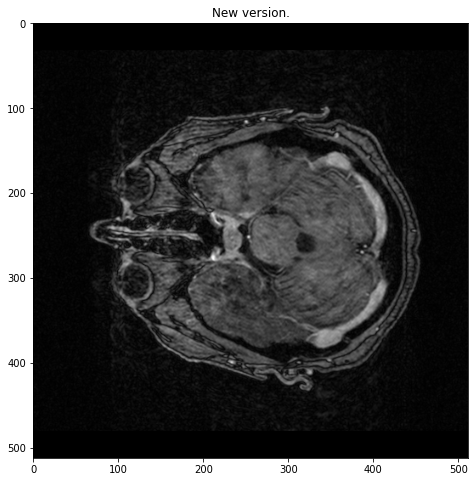

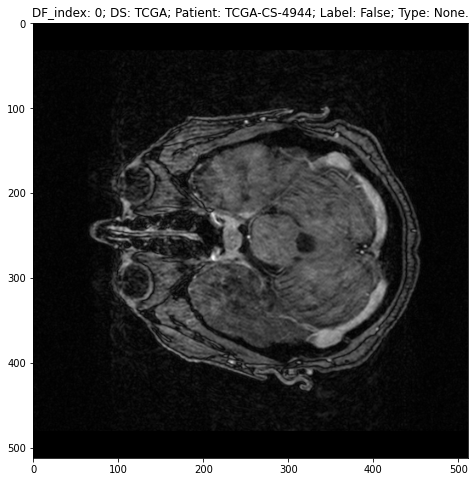

[None 'LGG' 'GBM' 'Meningioma' 'Glioma' 'Pituitary Tumor']


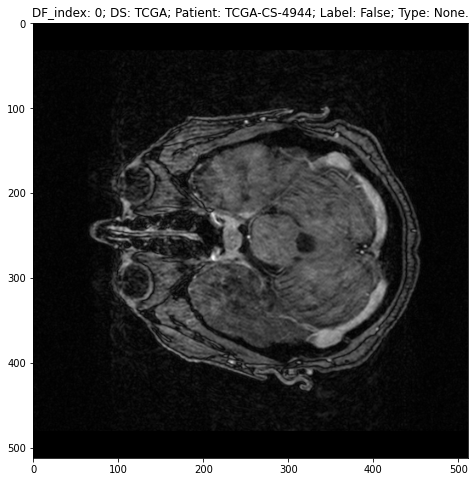

In [55]:
val_df = EvaluateDataframe(total_df)

val_df.plot_images()